# Comparing sea ice extent from observations and Earth System Models
Sea ice extent was calculated following [Hobbs et al 2016](10.1016/j.gloplacha.2016.06.008). They added the area of all ocean grid cells that had a sea ice concentration of 15\% or higher.

Sea ice concentration data is the same used in [sea ice concentration comparisons](https://github.com/Fish-MIP/SOMEME/blob/main/scripts/Comparing_sic_data_obs_models.ipynb).

## Loading relevant libraries

In [1]:
#Packages for file management
import os
from glob import glob

#Data wrangling
import pandas as pd
import numpy as np
import xarray as xr
from itertools import cycle
import string
import re

#Packages for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmocean as cm
import matplotlib.gridspec as gridspec

## Setting working directory

In [2]:
os.chdir('/g/data/jk72/la6889/FishMIP/SOMEME/')

## Calculating sea ice extent

### GFDL-MOM6-COBALT3

In [300]:
#Loading GFDL data
gfdl_sic = xr.open_dataarray('data/gfdl-mom6-cobalt2_obsclim_siconc_15arcmin_global_monthly_1961_2010.nc')
gfdl_sic = gfdl_sic.sel(lat = slice(-30, -90))

#Loading GFDL area of grid cells
gfdl_area = xr.open_dataarray('data/gfdl-mom6-cobalt2_areacello_15arcmin_global_fixed.nc')
#Transform from m2 to km2
gfdl_area = gfdl_area.sel(lat = slice(-30, -90))*1e-6

# #Calculate sea ice extent
gfdl_sie = xr.where(gfdl_sic >= 15, gfdl_area, np.nan)
gfdl_sie = gfdl_sie.sum(('lat', 'lon'))

In [301]:
#Calculate mean and standard deviation
month_mean = gfdl_sie.groupby('time.month').mean().expand_dims({'type': ['mean']})
month_std = gfdl_sie.groupby('time.month').std().expand_dims({'type': ['std']})

#Store in a single data frame
gfdl_sie_month = xr.concat([month_mean, month_std], 
                               dim = 'type').to_pandas().transpose()

#Adding units
gfdl_sie_month['unit'] = 'km2'

#Save outputs
gfdl_sie_month.to_csv('data/CMIP6/sea_ice_extent_ts/gfdl_sie_monthly.csv')

#Check results
gfdl_sie_month

type,mean,std,unit
month,,,
1,4.090323e+06,7.797305e+05,km2
2,2.457986e+06,3.489240e+05,km2
3,3.618672e+06,5.559897e+05,km2
4,6.440602e+06,7.048976e+05,km2
5,9.695916e+06,7.730833e+05,km2
6,1.268040e+07,7.914423e+05,km2
7,1.505907e+07,7.088457e+05,km2
8,1.655846e+07,7.785661e+05,km2
9,1.704904e+07,8.790415e+05,km2


### CMIP6 models
We will load climatological means calculated from each CMIP6 model included in our ensemble except UKESM1-0-LL because we could not find area of the grid cell.

In [302]:
#Getting list of all models available in folder
cmip_files = glob('data/CMIP6/clean_CMIP6/*.nc')
cmip_files = [f for f in cmip_files if 'UKESM' not in f]
#List area of grid cell files from ESGF
cmip_area = glob('data/CMIP6/*areacello*')

#Initiliasing empty list to store results
cmip_ds = []

#Loop through each file
for f in cmip_files:   
    #Load sea ice data
    ice_ds = xr.open_dataarray(f)
    #If "type" dimension exists remove it
    if 'type' in ice_ds.coords:
        ice_ds = ice_ds.drop_vars('type')
    #Get name of model to add as dimension
    [model] = re.findall('SImon_(.*)_hist', os.path.basename(f))        
    #Identify area file for model
    [area_file] = [f for f in cmip_area if f'{model}.' in f]
    #Load area file
    area_ds = xr.open_dataarray(area_file)
    #If area is in m2, transform to km2
    if area_ds.attrs['units'] == 'm2':
        area_ds = area_ds*1e-6
    #Identify grid cells with concentration of 15% or more
    mask_sie = xr.where(ice_ds >= 15, 1, np.nan)
    #Mask sea ice area
    cmip_sie = mask_sie*area_ds
    #Calculate sea ice extent
    cmip_sie = cmip_sie.sum(('x', 'y'))
    
    #Calculate mean and standard deviation
    month_mean = cmip_sie.groupby('time.month').mean().expand_dims({'type': ['mean']})
    month_std = cmip_sie.groupby('time.month').std().expand_dims({'type': ['std']})

    #Store in a single data frame
    cmip6_sie_month = xr.concat([month_mean, month_std], 
                               dim = 'type').to_pandas().transpose()

    #Adding units and CMIP6 model
    cmip6_sie_month['unit'] = 'km2'
    cmip6_sie_month['model'] = model

    #Storing in empty list
    cmip_ds.append(cmip6_sie_month)

#Transform into a single data frame
cmip_ds = pd.concat(cmip_ds)

#Save outputs 
cmip_ds.to_csv('data/CMIP6/sea_ice_extent_ts/cmip6_sie_monthly.csv')

#Check results
cmip_ds

type,mean,std,unit,model
month,,,,
1,6.106992e+06,722528.814372,km2,ACCESS-ESM1-5
2,3.330505e+06,556591.100255,km2,ACCESS-ESM1-5
3,3.296174e+06,489052.436657,km2,ACCESS-ESM1-5
4,4.873899e+06,619816.317941,km2,ACCESS-ESM1-5
5,8.205102e+06,819031.678572,km2,ACCESS-ESM1-5
...,...,...,...,...
8,1.587457e+07,602104.406574,km2,CESM2
9,1.666653e+07,580629.508708,km2,CESM2
10,1.684630e+07,499832.109403,km2,CESM2


### Observations (passive microwave satellite data)
This product has a resolution of 25 km.

In [303]:
#File containing all SIC data - Adding search term for monthly and Southern Ocean data ("monthly_sh")
base_sic_path = '/g/data/hh5/tmp/cosima/observations/NOAA/G02202_V4/*monthly_sh_197811_202212*.nc'

#Get a list of paths with all available data
[monthly_sic_path] = glob(base_sic_path)
#Loading dataset
nsidc_ds = xr.open_dataset(monthly_sic_path, decode_times = False, autoclose = True)['cdr_seaice_conc_monthly']

#Getting time units to decode time correctly
time_units = nsidc_ds.time.units
#Decode time
decoded_time = xr.conventions.times.decode_cf_datetime(nsidc_ds.time, time_units)
#Rename time dimension
nsidc_ds = nsidc_ds.rename({'tdim': 'time'})
#Add decoded time to dataset
nsidc_ds['time'] = ('time', decoded_time, {'long_name': 'time', 'decoded_using': time_units})

#Subset dataset for period of interest
nsidc_ds = nsidc_ds.sel(time = slice('1982', '2010'))

#Change flag values (any pixels with values above 1) to NAs
nsidc_ds = xr.where(nsidc_ds > 1, np.nan, nsidc_ds)

/jobfs/114299215.gadi-pbs/ipykernel_3163492/101958983.py:14: UserWarning: rename 'tdim' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  nsidc_ds = nsidc_ds.rename({'tdim': 'time'})


In [304]:
#Calculate sea ice extent per time step
nsidc_sie = xr.where(nsidc_ds >= 0.15, (25**2), np.nan)
nsidc_sie = nsidc_sie.sum(('x', 'y'))

#Calculate monthly mean and standard deviation
month_mean = nsidc_sie.groupby('time.month').mean().expand_dims({'type': ['mean']})
month_std = nsidc_sie.groupby('time.month').std().expand_dims({'type': ['std']})

#Store in a single data frame
nsidc_sie_month = xr.concat([month_mean, month_std], 
                               dim = 'type').to_pandas().transpose()

#Adding units
nsidc_sie_month['unit'] = 'km2'

#Saving results
nsidc_sie_month.to_csv('data/CMIP6/sea_ice_extent_ts/observations_sie_monthly.csv')

#Check results
nsidc_sie_month

type,mean,std,unit
month,,,
1,5.315086e+06,1.186526e+06,km2
2,3.217909e+06,3.756670e+05,km2
3,4.624634e+06,4.700842e+05,km2
4,7.714698e+06,4.944896e+05,km2
5,1.124744e+07,5.051610e+05,km2
6,1.456228e+07,4.460045e+05,km2
7,1.724052e+07,3.617454e+05,km2
8,1.906905e+07,3.219129e+05,km2
9,1.981825e+07,3.889225e+05,km2


Text(0, 0.5, 'Mean sea ice extent ($1e^{7} km^{2}$)')

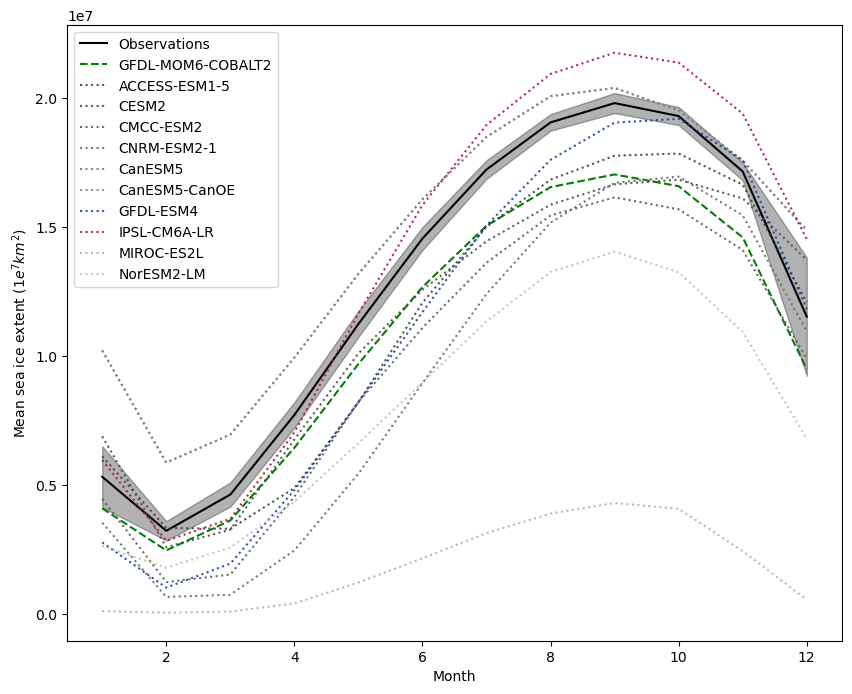

In [305]:
#Start figure
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)

#Plot observations mean
nsidc_sie_month.plot(y = 'mean', ax = ax, color = 'black', label = 'Observations')
#Plot observations standard deviation
ax.fill_between(nsidc_sie_month.index.values, 
                (nsidc_sie_month['mean']+nsidc_sie_month['std']).values,
                (nsidc_sie_month['mean']-nsidc_sie_month['std']).values,
                alpha = 0.3, color = 'black')

#Plot GFDL-MOM6-COBALT2 mean
gfdl_sie_month.plot(y = 'mean', ax = ax, color = 'green', label = 'GFDL-MOM6-COBALT2',
                   ls = 'dashed')

#Getting grey scale for plotting CMIP6 models
colors1 = plt.cm.gray(np.linspace(0.25, 0.75, 10))
#Replacing colors for GFDL-ESM4 and IPSL-CM6A-LR
colors1[6] = np.array([0.0892, 0.2546, 0.6562, 1.])
colors1[7] = np.array([0.6562, 0.0892, 0.2546, 1.])

#Plot CMIP6 models
for i, (mod, da) in enumerate(cmip_ds.groupby('model')):
    da.plot(y = 'mean', ax = ax, alpha = 0.9, label = mod, color = colors1[i], 
            ls = 'dotted')

plt.xlabel('Month')
plt.ylabel('Mean sea ice extent ($1e^{7} km^{2}$)')